# Training: tips and tricks

Don't forget to set your "hardware accelerator" to "GPU": from the top menu, do `Runtime` > `Change runtime type` > set "Hardware accelerator to "`GPU` and click `Save`.*

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/my_ml_2023/session-8


In [ ]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random

# import import_ipynb
import utils



# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)

## Preprocessing

In this part, we'll work on the text classification dataset in IMDB (mostly because we know that well already). We download ...

In [ ]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data()

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
word_index = imdb.get_word_index() # word to index
reverse_word_index = dict([(value + 3 , key) for (key, value) in word_index.items()]) # index to word
reverse_word_index[0] = '[PAD]'
reverse_word_index[1] = '[START]'
reverse_word_index[2] = '[UNK]'
reverse_word_index[3] = '[UNS]'


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def decode_data(dataset):
  decoded_data = []
  for item in dataset:
    decoded_review = ' '.join([reverse_word_index[i] for i in item])
    decoded_data.append(decoded_review)
  return decoded_data


decoded_train_data = decode_data(train_data)
decoded_test_data = decode_data(test_data)


In [ ]:
decoded_train_data[0]

"[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

... and preprocess it, as before:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

x_train = tfidf_vectorizer.fit_transform(decoded_train_data).todense()
x_test = tfidf_vectorizer.transform(decoded_test_data).todense()

y_train = np.asarray(train_labels)
y_test = np.asarray(test_labels)

x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

print(x_train.shape)
print(x_dev.shape)
print(x_test.shape)

print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)

(22500, 5000)
(2500, 5000)
(25000, 5000)
(22500,)
(2500,)
(25000,)


Let's covert data to the PyTorch format. Always print the shape of the data you are working with and make sure that the dimensions make sense to you.

In [ ]:
def np2iter(x, y, shuffle=True):
  x = torch.tensor(x, dtype=torch.float)
  # y = np.expand_dims(y, axis=1)
  y = torch.tensor(y, dtype=torch.long)
  print(y.shape)

  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=64, shuffle=shuffle)

train_iter = np2iter(x_train, y_train, shuffle=True)
dev_iter =  np2iter(x_dev, y_dev, shuffle=False)
test_iter =  np2iter(x_test, test_labels, shuffle=False)

torch.Size([22500])
torch.Size([2500])
torch.Size([25000])


## Model

Let us start with the simple linear model:

In [ ]:
from sklearn.metrics import accuracy_score

class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.layer = nn.Linear(in_features=x_train.shape[1], out_features=2)


  def forward(self, x):
    return self.layer(x)

def val_acc(y_pred, y_test):
  y_pred = np.argmax(y_pred, axis=1)
  return accuracy_score(y_pred, y_test)


Remember, such models are called **shallow** because they don't have (m)any hidden layers that could help in modelling good intermediary representations of the instances, on which to base the final classification decision at the output layers. Let's train this network as we did before, with Stochastic Gradient Descent (SGD), a small learning rate and a reasonable batch size of 64:

In [ ]:
classification_model = LinearModel()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=1e-3),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=20)

epoch 1 train loss: 0.6930 val_cls: 0.6927 val_acc: 0.5316
epoch 2 train loss: 0.6927 val_cls: 0.6924 val_acc: 0.5480
epoch 3 train loss: 0.6924 val_cls: 0.6921 val_acc: 0.5652
epoch 4 train loss: 0.6921 val_cls: 0.6918 val_acc: 0.5808
epoch 5 train loss: 0.6918 val_cls: 0.6915 val_acc: 0.5980
epoch 6 train loss: 0.6914 val_cls: 0.6913 val_acc: 0.6132
epoch 7 train loss: 0.6911 val_cls: 0.6910 val_acc: 0.6276
epoch 8 train loss: 0.6908 val_cls: 0.6907 val_acc: 0.6400
epoch 9 train loss: 0.6905 val_cls: 0.6904 val_acc: 0.6544
epoch 10 train loss: 0.6902 val_cls: 0.6901 val_acc: 0.6664
epoch 11 train loss: 0.6899 val_cls: 0.6898 val_acc: 0.6728
epoch 12 train loss: 0.6896 val_cls: 0.6895 val_acc: 0.6824
epoch 13 train loss: 0.6893 val_cls: 0.6892 val_acc: 0.6888
epoch 14 train loss: 0.6890 val_cls: 0.6889 val_acc: 0.6952
epoch 15 train loss: 0.6887 val_cls: 0.6886 val_acc: 0.6996
epoch 16 train loss: 0.6884 val_cls: 0.6883 val_acc: 0.7060
epoch 17 train loss: 0.6881 val_cls: 0.6881 val_a

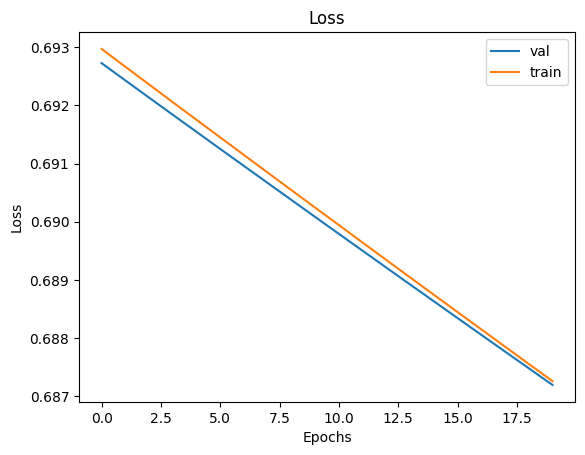

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

> Note, this loss/objective function is to be preferred for classification problems (better works).

If we look at the printed output of the `train` function, both for the training and development performance, there is:

- good news: we see a very similar pattern in the (fairly consistent) decrease for the train and dev scores: that is healthy, because it indicates that we aren't overfitting (yet).
- bad news: we are nowhere near a good fit on the training data ( we don't see the saturation of the loss), after 20 epochs of training.

Possible solutions:
- train longer
- play with the learning rate (to train faster)



Let us add a hidden layer to increase the size or expressive capacity of our model, in order to get a better fit of the training data.

**Should the results be better if we train this model with the previous parameters?**


**Remember:** larger models with more parameters should, in principle, always give you a better fit of the training data if you train the model long enough (the question is always whether that better training fit will also translate to better predictions on the dev or test data).

In [ ]:
class DeepModel(nn.Module):
  def __init__(self):
    super(DeepModel, self).__init__()
    self.layer = nn.Sequential(nn.Linear(in_features=x_train.shape[1], out_features=500),
                                nn.ReLU(),
                                nn.Linear(in_features=500, out_features=2))


  def forward(self, x):
    return self.layer(x)

Let us fit the model again, with exactly the same settings:

In [ ]:
classification_model = DeepModel()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=1e-3),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=20)

epoch 1 train loss: 0.6935 val_cls: 0.6934 val_acc: 0.5000
epoch 2 train loss: 0.6933 val_cls: 0.6933 val_acc: 0.5000
epoch 3 train loss: 0.6931 val_cls: 0.6931 val_acc: 0.5000
epoch 4 train loss: 0.6930 val_cls: 0.6930 val_acc: 0.5000
epoch 5 train loss: 0.6929 val_cls: 0.6929 val_acc: 0.5000
epoch 6 train loss: 0.6929 val_cls: 0.6929 val_acc: 0.5000
epoch 7 train loss: 0.6928 val_cls: 0.6928 val_acc: 0.5000
epoch 8 train loss: 0.6927 val_cls: 0.6927 val_acc: 0.5004
epoch 9 train loss: 0.6926 val_cls: 0.6927 val_acc: 0.5044
epoch 10 train loss: 0.6926 val_cls: 0.6926 val_acc: 0.5100
epoch 11 train loss: 0.6925 val_cls: 0.6926 val_acc: 0.5300
epoch 12 train loss: 0.6925 val_cls: 0.6925 val_acc: 0.5660
epoch 13 train loss: 0.6924 val_cls: 0.6924 val_acc: 0.5812
epoch 14 train loss: 0.6923 val_cls: 0.6924 val_acc: 0.5988
epoch 15 train loss: 0.6923 val_cls: 0.6923 val_acc: 0.6104
epoch 16 train loss: 0.6922 val_cls: 0.6923 val_acc: 0.6252
epoch 17 train loss: 0.6922 val_cls: 0.6922 val_a

> *Note*: if you'd change your runtime back to CPU, you would see how much slower this network has become to train, with all these additional weights. Because we are running the GPU already, this difference isn't so pronounced.




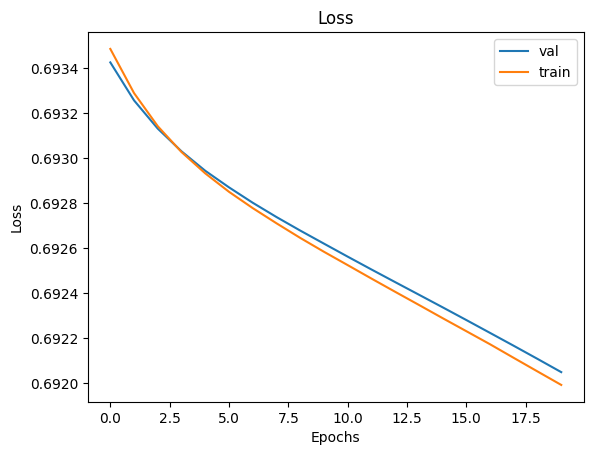

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Interestingly, the network is not only slower to train (cf. time), but also quite a bit slower to converge (cf. loss scores). It is quite expected because the network has become larger and more complex, so that it has also become more difficult to train.

One important way to **speed up convergence**, is to consider alternative optimizers than just the vanilla SGD that we have used so far. One commonly used optimizer is the Adam optimizer, which controls a **separate, adaptive learning rate for each parameter** in the network. We'll skip the math behind this optimizer, since this is a simple string drop-in replacement in `PyTorch`. We set the initial learning rate (for all parameters) to the
same value (as before). Note that `Adam` can adapt the learning rate during training, so that you can in principle also start with smaller or larger values.

We start by applying the Adam optimizer for our shallow model:

In [ ]:
classification_model = LinearModel()
classification_model = classification_model.cuda()

# check
history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.Adam(classification_model.parameters(), lr=1e-3),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=20)

epoch 1 train loss: 0.6276 val_cls: 0.5734 val_acc: 0.8392
epoch 2 train loss: 0.5270 val_cls: 0.4999 val_acc: 0.8508
epoch 3 train loss: 0.4625 val_cls: 0.4513 val_acc: 0.8604
epoch 4 train loss: 0.4175 val_cls: 0.4165 val_acc: 0.8692
epoch 5 train loss: 0.3844 val_cls: 0.3905 val_acc: 0.8728
epoch 6 train loss: 0.3587 val_cls: 0.3705 val_acc: 0.8772
epoch 7 train loss: 0.3382 val_cls: 0.3544 val_acc: 0.8772
epoch 8 train loss: 0.3214 val_cls: 0.3416 val_acc: 0.8784
epoch 9 train loss: 0.3073 val_cls: 0.3309 val_acc: 0.8804
epoch 10 train loss: 0.2953 val_cls: 0.3220 val_acc: 0.8816
epoch 11 train loss: 0.2850 val_cls: 0.3145 val_acc: 0.8824
epoch 12 train loss: 0.2760 val_cls: 0.3081 val_acc: 0.8856
epoch 13 train loss: 0.2679 val_cls: 0.3027 val_acc: 0.8848
epoch 14 train loss: 0.2608 val_cls: 0.2981 val_acc: 0.8836
epoch 15 train loss: 0.2544 val_cls: 0.2939 val_acc: 0.8872
epoch 16 train loss: 0.2487 val_cls: 0.2904 val_acc: 0.8868
epoch 17 train loss: 0.2435 val_cls: 0.2875 val_a

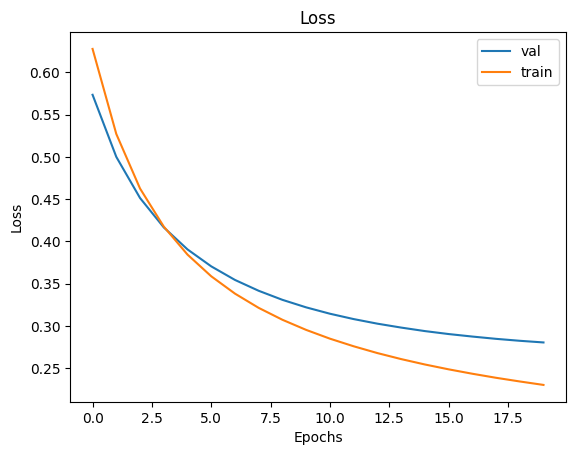

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As you can see, the speed-up in the convergence is quite impressive: within a few epochs, our training accuracy reaches the lower nineties and our dev scores wiggle around the upper eighties.

This is often what you will want to see in a model: remember, **as soon as you run out of training loss, the model isn't able to learn anything anymore!**


 For the larger/deeper model, the effect is even more outspoken:

In [ ]:
classification_model = DeepModel()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.Adam(classification_model.parameters(), lr=1e-3),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=20)

epoch 1 train loss: 0.3315 val_cls: 0.2740 val_acc: 0.8860
epoch 2 train loss: 0.2123 val_cls: 0.2944 val_acc: 0.8780
epoch 3 train loss: 0.1811 val_cls: 0.3273 val_acc: 0.8776
epoch 4 train loss: 0.1517 val_cls: 0.3351 val_acc: 0.8692
epoch 5 train loss: 0.1134 val_cls: 0.3807 val_acc: 0.8704
epoch 6 train loss: 0.0682 val_cls: 0.4511 val_acc: 0.8680
epoch 7 train loss: 0.0323 val_cls: 0.5082 val_acc: 0.8664
epoch 8 train loss: 0.0129 val_cls: 0.6016 val_acc: 0.8604
epoch 9 train loss: 0.0054 val_cls: 0.6645 val_acc: 0.8616
epoch 10 train loss: 0.0028 val_cls: 0.7104 val_acc: 0.8616
epoch 11 train loss: 0.0018 val_cls: 0.7464 val_acc: 0.8632
epoch 12 train loss: 0.0012 val_cls: 0.7778 val_acc: 0.8624
epoch 13 train loss: 0.0009 val_cls: 0.8084 val_acc: 0.8636
epoch 14 train loss: 0.0007 val_cls: 0.8335 val_acc: 0.8636
epoch 15 train loss: 0.0005 val_cls: 0.8546 val_acc: 0.8624
epoch 16 train loss: 0.0004 val_cls: 0.8764 val_acc: 0.8632
epoch 17 train loss: 0.0003 val_cls: 0.8964 val_a

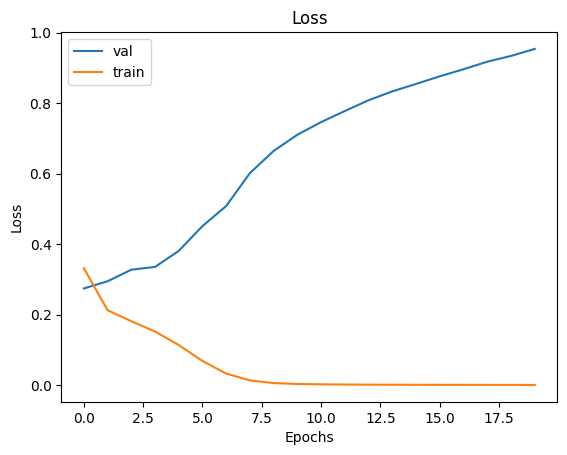

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In the 7th-8th epoch, the model has been able to provide an almost perfect fit of the training data (100%): the training loss has become *tiny* by then. Note, however, that the validation loss has started to grow by then -- even when our training loss is still happily racing down. Thus, we can see how Adam speeds up our fit, but doesn't *necessarily* improve our generalization (cf. performance on the dev set). This might be a bit **counterintuitive**, but this is very important to remember: **the model that does best on the training set, is not necessarily the model that you should prefer**. In fact, the shallow model above gives us a better performance on the dev set and should be prefered at this stage. Thus, finding a good model is the art of knowing how to balance the over- and under-expressiveness of a model, and finding a healthy trade-off between under- and overfitting.

Below, we fit an even deeper model to this dataset: this model too, is more difficult to train but will not necessarily lead to better dev performance. Underfitting is a much more rare phenomenon nowadays in deep learning than overfitting: **decreasing** your model's capacity is always an important strategy to combat overfitting that you should consider.

In [ ]:
class DeepModel2(nn.Module):
  def __init__(self):
    super(DeepModel2, self).__init__()
    self.layer = nn.Sequential(nn.Linear(in_features=x_train.shape[1], out_features=500),
                                nn.ReLU(),
                                nn.Linear(in_features=500, out_features=500),
                                nn.ReLU(),
                                nn.Linear(in_features=500, out_features=2))


  def forward(self, x):
    return self.layer(x)


In [ ]:
classification_model = DeepModel2()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.Adam(classification_model.parameters(), lr=1e-3),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=20)

epoch 1 train loss: 0.3307 val_cls: 0.2818 val_acc: 0.8848
epoch 2 train loss: 0.2084 val_cls: 0.2938 val_acc: 0.8784
epoch 3 train loss: 0.1428 val_cls: 0.3408 val_acc: 0.8692
epoch 4 train loss: 0.0522 val_cls: 0.5377 val_acc: 0.8672
epoch 5 train loss: 0.0080 val_cls: 0.6838 val_acc: 0.8696
epoch 6 train loss: 0.0011 val_cls: 0.8873 val_acc: 0.8676
epoch 7 train loss: 0.0002 val_cls: 0.9986 val_acc: 0.8712
epoch 8 train loss: 0.0001 val_cls: 1.0912 val_acc: 0.8704
epoch 9 train loss: 0.0000 val_cls: 1.1683 val_acc: 0.8684
epoch 10 train loss: 0.0000 val_cls: 1.2462 val_acc: 0.8676
epoch 11 train loss: 0.0000 val_cls: 1.3599 val_acc: 0.8680
epoch 12 train loss: 0.0000 val_cls: 1.4491 val_acc: 0.8676
epoch 13 train loss: 0.0000 val_cls: 1.5164 val_acc: 0.8668
epoch 14 train loss: 0.0000 val_cls: 1.5736 val_acc: 0.8668
epoch 15 train loss: 0.0000 val_cls: 1.6248 val_acc: 0.8668
epoch 16 train loss: 0.0000 val_cls: 1.6678 val_acc: 0.8672
epoch 17 train loss: 0.0000 val_cls: 1.7080 val_a

The loss curve can help demonstrate precisely how severe the overfitting was in this case! Worse results were expected because we increased the complexity of the model that gave more memorization capacity to the model.

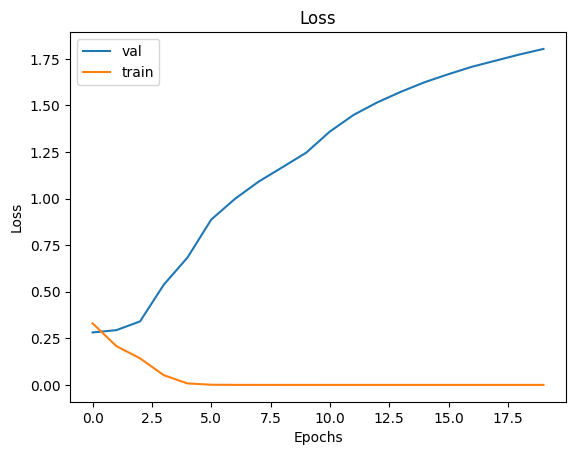

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Whereas the training loss has reached an absolute minimum by the 5th epoch, the dev loss is wildly racing up as we keep on training. This is a situation that you will like to avoid at all cost.

Various regularization strategies exist and we already covered to the two simplest ones:
- decreasing your model size (aim for a **minimally adequate model**, cf. Occam's razor)
- apply **early stopping**: don't train for longer than strictly necessary -- you don't gain anything from this.

In this notebook, we'll cover two additional techniques:
- dropout
- weight regularization

Both are commonly applied in modern neural networks, and you should consider them as a **standard piece of equipment** in your toolkit. Especially regarding dropout, **don't be shy**: **apply dropout generously** (but don't apply it after the last layer). In `PyTorch`, dropout is implemented as a simple layer that you can add, like you would add with any other kind of layer that you already know. The layer requires a single parameter, i.e. the proportion of features that you would like to "mask" in the input to the next layer in your stack. (This sort of masking only happens during training: we takes care of this by switching off the option at test time, for instance). A useful default is `0.5` which means that a random half of the features from the previous layer get masked -- and in the literature you will even see more extreme values (e.g. `0.8`), especially for larger models that are being applied to smaller datasets.

In [ ]:
class DeepModel3(nn.Module):
  def __init__(self):
    super(DeepModel3, self).__init__()
    self.layer = nn.Sequential(nn.Dropout(p=0.7),
                               nn.Linear(in_features=x_train.shape[1], out_features=500),
                                nn.Dropout(p=0.7),
                                nn.ReLU(),
                                nn.Linear(in_features=500, out_features=500),
                                nn.Dropout(p=0.7),
                                nn.ReLU(),
                                nn.Linear(in_features=500, out_features=2))


  def forward(self, x):
    return self.layer(x)

In [ ]:
classification_model = DeepModel3()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.Adam(classification_model.parameters(), lr=1e-3),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=20)

epoch 1 train loss: 0.5279 val_cls: 0.3518 val_acc: 0.8628
epoch 2 train loss: 0.4423 val_cls: 0.3167 val_acc: 0.8740
epoch 3 train loss: 0.4328 val_cls: 0.3305 val_acc: 0.8752
epoch 4 train loss: 0.4257 val_cls: 0.3385 val_acc: 0.8748
epoch 5 train loss: 0.4155 val_cls: 0.3198 val_acc: 0.8780
epoch 6 train loss: 0.4184 val_cls: 0.3180 val_acc: 0.8824
epoch 7 train loss: 0.4109 val_cls: 0.3148 val_acc: 0.8824
epoch 8 train loss: 0.4099 val_cls: 0.3168 val_acc: 0.8816
epoch 9 train loss: 0.4058 val_cls: 0.3072 val_acc: 0.8764
epoch 10 train loss: 0.4088 val_cls: 0.3236 val_acc: 0.8792
epoch 11 train loss: 0.4036 val_cls: 0.3171 val_acc: 0.8772
epoch 12 train loss: 0.4016 val_cls: 0.3125 val_acc: 0.8760
epoch 13 train loss: 0.3946 val_cls: 0.3137 val_acc: 0.8836
epoch 14 train loss: 0.3906 val_cls: 0.3023 val_acc: 0.8840
epoch 15 train loss: 0.3881 val_cls: 0.3106 val_acc: 0.8860
epoch 16 train loss: 0.3951 val_cls: 0.3197 val_acc: 0.8892
epoch 17 train loss: 0.3876 val_cls: 0.3123 val_a

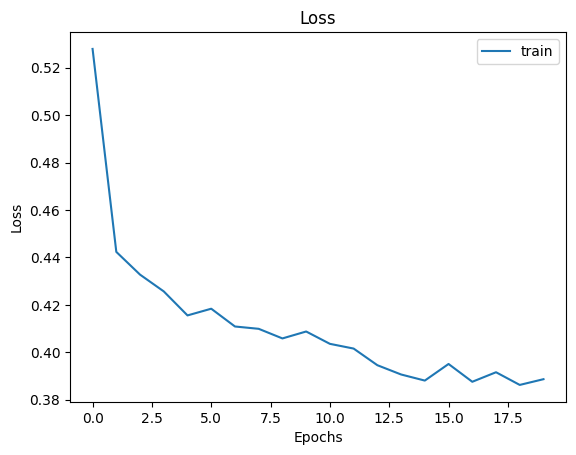

In [ ]:
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In the model definition above, we even inserted a dropout layer immediately after the input layer: this is a bit extreme, in the sense that our model for each instance even only gets to see less than half of the column's in `x_train`. If we look at the loss curves, you'll nevertheless see that the model is better in learning:

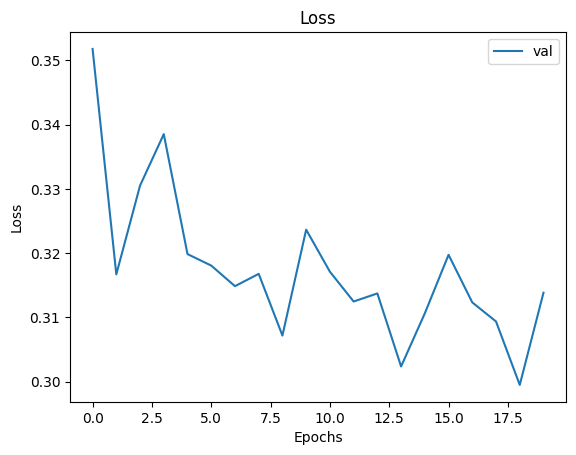

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

One remarkable aspect of this graph is the dev loss curve: although we reach a close to maximal performance from the first epochs onwards, it doesn't go up notably afterwards (as was previously the case). This is an important advantage of dropout: even when you keep on training, the risk of overfitting is significantly reduced.

Finally, you can also add weights regularization to your model definition. This is a slightly older technique, that isn't used as profusely anymore as before, but still it can help a lot, if you  apply it well. Below, we add it to our train function. Below, you will notice how this strategy too can (quite aggressively!) slow down training -- which is good in this context.

In [ ]:
classification_model = DeepModel2()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            l2_regularization=utils.L2Regularization(0.02),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.Adam(classification_model.parameters(), lr=1e-3),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=20)

epoch 1 train loss: 0.6887 val_cls: 0.3120 val_acc: 0.8800
epoch 2 train loss: 0.6163 val_cls: 0.3028 val_acc: 0.8744
epoch 3 train loss: 0.5938 val_cls: 0.3005 val_acc: 0.8756
epoch 4 train loss: 0.5724 val_cls: 0.2995 val_acc: 0.8776
epoch 5 train loss: 0.5584 val_cls: 0.2897 val_acc: 0.8852
epoch 6 train loss: 0.5461 val_cls: 0.2912 val_acc: 0.8828
epoch 7 train loss: 0.5337 val_cls: 0.2915 val_acc: 0.8772
epoch 8 train loss: 0.5286 val_cls: 0.2861 val_acc: 0.8796
epoch 9 train loss: 0.5230 val_cls: 0.2873 val_acc: 0.8804
epoch 10 train loss: 0.5186 val_cls: 0.2839 val_acc: 0.8840
epoch 11 train loss: 0.5149 val_cls: 0.2812 val_acc: 0.8892
epoch 12 train loss: 0.5109 val_cls: 0.2839 val_acc: 0.8844
epoch 13 train loss: 0.5081 val_cls: 0.2851 val_acc: 0.8788
epoch 14 train loss: 0.5049 val_cls: 0.2837 val_acc: 0.8824
epoch 15 train loss: 0.5050 val_cls: 0.2824 val_acc: 0.8828
epoch 16 train loss: 0.4993 val_cls: 0.2872 val_acc: 0.8800
epoch 17 train loss: 0.4995 val_cls: 0.2816 val_a

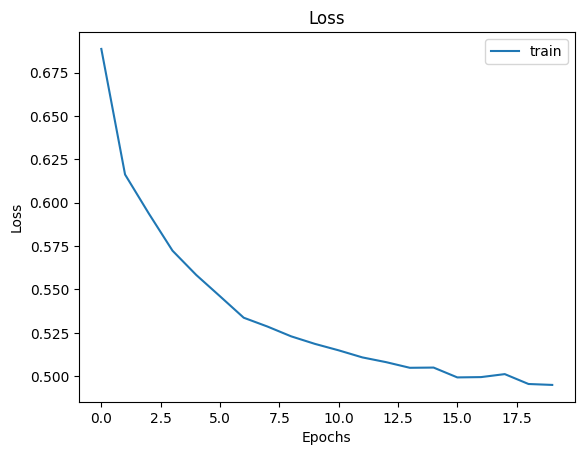

In [ ]:
# epochs = range(1, num_epochs + 1)
# train_loss = history.history['loss']
# dev_loss = history.history['val_loss']

# plt.plot(epochs, train_loss, 'b', label='train')
# plt.plot(epochs, dev_loss, 'r', label='dev')
# plt.title('Loss curves')
# plt.xlabel('Epochs')
# plt.legend()
# plt.ylabel('Binary Crossentropy');

plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

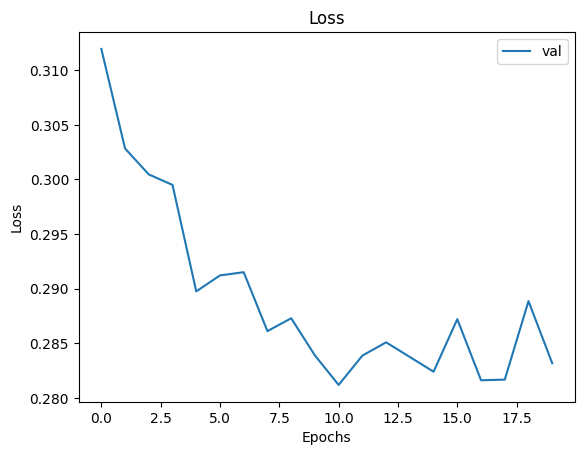

In [ ]:

plt.plot(history['val_cls'],  label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()